<h1>Land Use Classifier</h1>
<p> Created by Zane Durante </p>
<p>
    This is a classifier for categorizing land types by their use (i.e. roads, forest, buidlings, agricultural, etc.).  The data is from the University of California, Merced.  Since this is a simple multi-class classification problem, accuracy is our best metric.
</p>
<p>
    I will be using the fast.ai deep learning library to create and train a convolutional image classifier.
</p>
<p>
    Dataset from: Yi Yang and Shawn Newsam, "Bag-Of-Visual-Words and Spatial Extensions for Land-Use Classification," ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems (ACM GIS), 2010.
</p>

<h3>Step 1. Load the dataset</h3>
<p>
    The dataset is in a folder labeled 'data/UCMerced_LandUse' in the same location as this jupyter notebook.
</p>

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Fast.ai imports
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from fastai.io import *

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
path = 'data/UCMerced_LandUse/'
batch_size = 64
image_size = 256 # All images within this dataset are 256 x 256
arch = resnet34

In [4]:
files = os.listdir(path)
print("Files:", files)
path += 'Images/'

Files: ['readme.txt.bak', 'Images', 'readme.txt']


In [5]:
def load_data(path):
    tfms = tfms_from_model(arch, image_size, aug_tfms=transforms_top_down, max_zoom=1.05)
    data = ImageClassifierData.from_paths(path, tfms=tfms, bs=batch_size)
    return data

In [6]:
data = load_data(path)

<h3>Step 2. Create the model</h3>
<p>
        For this classification problem, we will be using fast.ai's convolutional learner model, which is pretrained on the imagenet dataset.  First, we will load the model using the default activations from the last layers (i.e. precompute=True).
</p>

In [7]:
learn=ConvLearner.pretrained(arch, data, precompute=True)

<h3> Step 3. Find learning rate </h3>
<p>
    To find the optimal learning rate of the model, we will use fast.ai's library function lr_find(), which plots the change in loss of the validation data with the learning rate increasing exponentially on the x axis.  We want to choose the highest learning rate that still causes the loss to decrease.
</p>

epoch      trn_loss   val_loss   accuracy                
    0      3.689463   361.109211 0.290476  



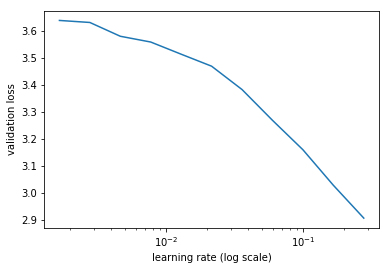

In [8]:
lrf = learn.lr_find()
learn.sched.plot()

In [9]:
# Since learning rate is decreasing throughout, we'll pick a high value
lr = .2

<h3> Step 4. Fit frozen model </h3>
<p> We will now train the activation layers of the model to predict what type of land we are seeing images of.  The convolutional layers will NOT be trained during this part.  We will be using Stochastic Gradient Descent with Restarts, a method that tries to avoid sub-optimal local minima by gradually decreasing the learning rate and then resetting it to its original value after a set number of epochs.
</p>

In [10]:
learn.fit(lr, 4, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                
    0      1.114027   0.844218   0.769048  
    1      0.78023    0.891988   0.769048                 
    2      0.608263   0.703397   0.788095                 
    3      0.484324   0.595591   0.819048                  



[array([0.59559]), 0.8190476167769659]

<h3>Step 5. Create differential learning rate and now train the unfrozen model</h3>
<p>
    We will now use a different learning rate for different parts of the model.  The earliest convolutional layers will have the smallest learning rate, with progressively deeper layers having higher learning rates.  
<p>

In [11]:
learn.unfreeze()
lrs = [lr/9, lr/3, lr]
learn.fit(lrs, 2, cycle_len=1, cycle_mult=3)

epoch      trn_loss   val_loss   accuracy                  
    0      0.400064   0.613615   0.828571  
    1      0.378954   0.728796   0.816667                  
    2      0.342641   0.663865   0.828571                  
    3      0.303652   0.600764   0.852381                  



[array([0.60076]), 0.852380953516279]

<h3> Step 6. Print loss function</h3>
<p>
    This loss function is very noisy.  This is possibly do to the very small nature of this dataset (80 training images per category).  
</p>

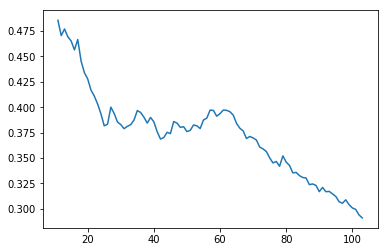

In [12]:
learn.sched.plot_loss()

<h3> Test Time Augmentation and Results</h3>
<p>
We will use test time augmentation to transform each of our test images into 4 separate augmented images.  Then, we take the mean of our predictions for each of the augmented images to calculate our prediction for the original image.
</p>

In [13]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)
print("Accuracy", accuracy_np(probs, y))

Accuracy 0.8833333333333333                  


<h3>Analysis</h3>
<p>
    Our final model had an accuracy of .8833, which is not terrible considering the small size of the dataset.  Additionally, the loss function indicates that our model is having a difficult time converging to a minimum for the dataset, likely due to the large variation within the small number of images in the dataset.  I purposefully ran relatively few epochs when training the model to attempt to counter overfitting the small dataset.  This was shown to be successful, as our validation accuracy was over 3 percent higher than the training data accuracy.  
</p>
<p>
    To improve the model, a larger dataset would clearly allow for a more robust training process, and would certainly increase the accuracy of the model.  Additionally, both the loss function and learning rates graphs were very abnormal.  I assumed this was because of the small size of the dataset, however there may be some other factor contributing to these strange graphs that is also upsetting the accuracy of the model.
</p>
<p>
    This notebook was finished on November 6, 2018
</p>